# Dataframe preparation and classifiers
## Front matter

In [30]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
import seaborn as sns
import matplotlib.pyplot as plt

import os
import pickle

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler

from processy import *

%matplotlib inline

np.random.seed(7834)

All visualizations will be saved in a new directory, images. This checks to be sure that such a directory exists. If not it creates it.

In [2]:
if 'images' not in os.listdir():
    os.mkdir('images')

The first time I scraped, I did not include the current time in the data scraping processes, so after I finished scraping I got the current time and put them here. These times may be off by at most 10 minutes, measured when the scraping finished. 

In [3]:
bpt_time = 1527700578.5692391
wpt_time = 1527714986.933973

## Data Cleaning
Right now at least, I see no reason not to combine all the text into one cell, separated by a space so the words aren't mashed together. I'll also assign a class variable (`0` for `r/BlackPeopleTwitter` and `1` for `r/WhitePeopleTwitter`).

In [37]:
df1 = prepare_dataframe(pd.read_csv('data/bpt_scraped_109pm_may30.csv.gz', compression="gzip", index_col=0), time=bpt_time, class_int=0)
df1.shape

FileNotFoundError: [Errno 2] No such file or directory: 'data/bpt_scraped_109pm_may30.csv.gz'

A little exploration of the data here: the script below makes a list of the 20 most common words in the text (not including stopwords).

In [5]:
top_20_words(df1['total_text'])

,0
like,144
just,125
don,98
people,72
shit,71
black,60
got,58
drake,53
good,49
know,48


The same for the `r/WhitePeopleTwitter` data.

In [6]:
df2 = prepare_dataframe(pd.read_csv('data/wpt_may30_516pm.csv', index_col=0), time=wpt_time, class_int=1)
df2.head()

,comments_this_post,ups,time_on_reddit,total_text,length_of_text,class
0,245,1152,29874.933973,Lions only live 10-14 years in the wild. If I ...,124,1
1,80,110,15877.933973,That's going to have a disastrous affect on th...,182,1
2,182,1394,51255.933973,"At 32 years old, I was grocery shopping and so...",180,1
3,29,29,14178.933973,"Oh, but us retail workers want to. We really w...",86,1
4,18,50,30874.933973,"Germany has Dads too Oh, dad. Got me again.",43,1


In [7]:
top_20_words(df2['total_text'])

,0
like,99
just,92
https,54
don,52
com,51
people,46
know,41
amp,41
time,39
think,36


Combining them into one dataframe.

In [8]:
df = pd.concat([df1, df2])
df.head()

,comments_this_post,ups,time_on_reddit,total_text,length_of_text,class
0,138,5,43776.569239,Fuck I thought it was Sophie Dee. That would h...,390,0
1,591,1464,58805.569239,"As a surprise to zero people, Pusha T is a lot...",106,0
2,72,439,13024.569239,"That or ""I am hiding a child, but you're hidin...",89,0
3,1153,3281,49606.569239,She should have talked about Mexicans. Nobody ...,108,0
4,66,55,12486.569239,I’ve never seen a single tweet blow up in a ce...,317,0


In [9]:
df.shape

(1747, 6)

## EDA

First, a look at the distributions of the numerical categories:

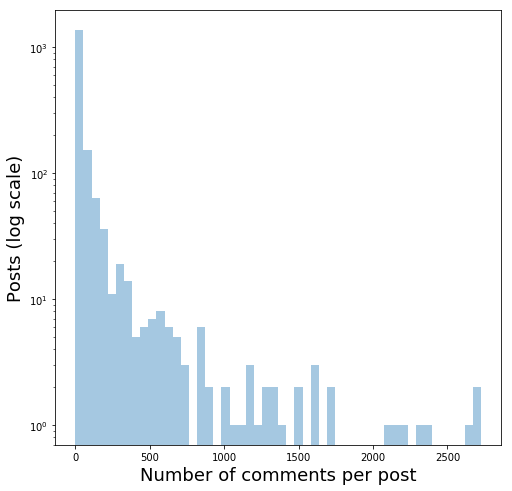

In [10]:
make_loghist(df['comments_this_post'], 
             "Number of comments per post", 
             "Posts (log scale)", 
             'Comments_log_scale.png')

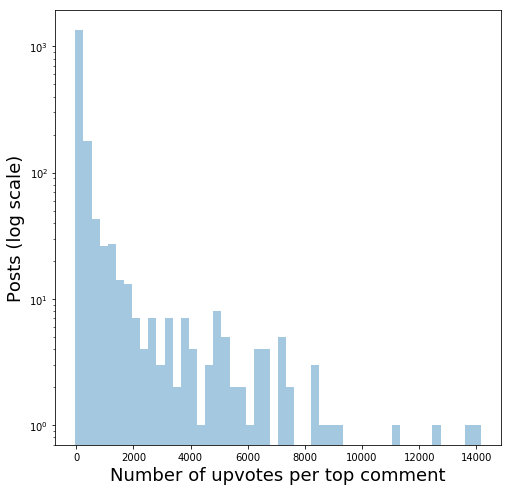

In [11]:
make_loghist(df['ups'], 
             "Number of upvotes per top comment", 
             "Posts (log scale)", 
             'Upvotes_log_scale.png')

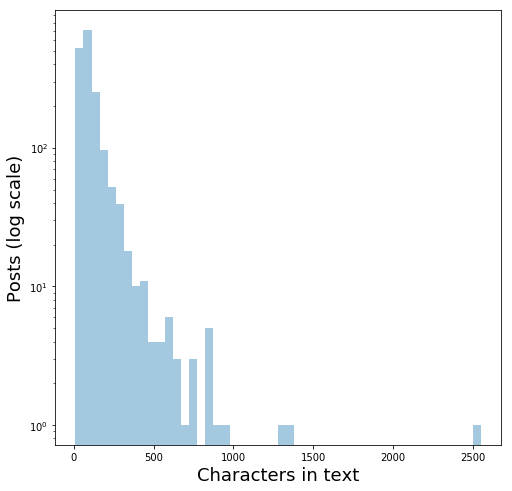

In [12]:
make_loghist(df['length_of_text'],
             "Characters in text", 
             "Posts (log scale)",
             'Characters_log_scale.png')

Are these features correlated?

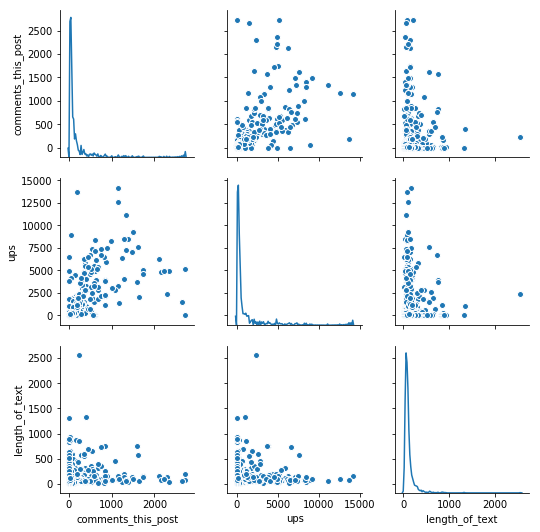

In [13]:
sns.pairplot(df[['comments_this_post','ups','length_of_text']], diag_kind='kde')
plt.savefig('images/pariplot.png')

Examining correlation more closely and differentiated between subreddits:

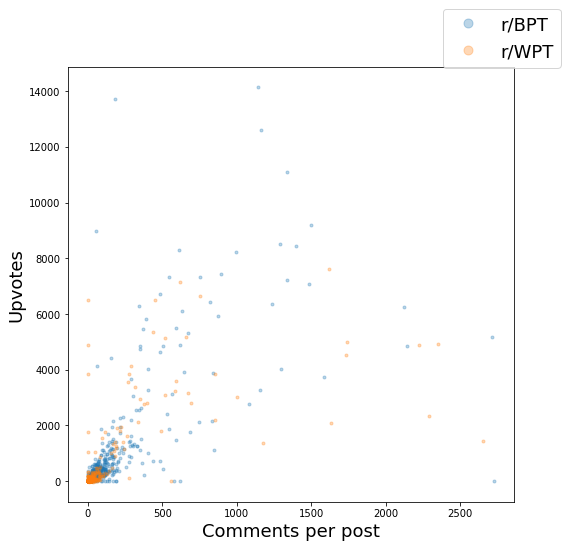

In [14]:
make_corrplot(df['comments_this_post'], df['ups'], df, "Comments per post", "Upvotes", 'comments-upvotes.png')

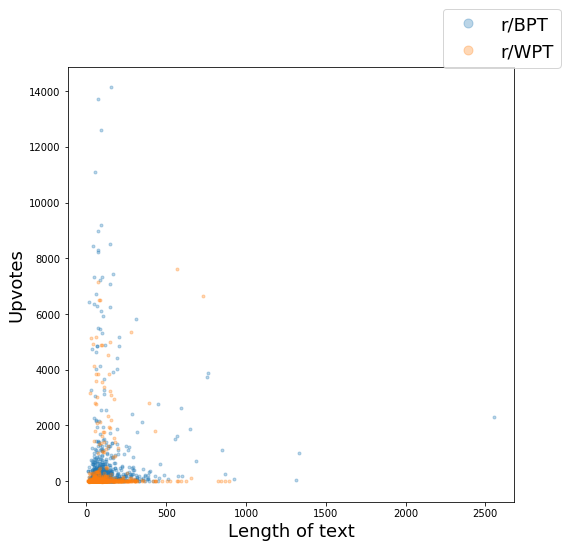

In [15]:
make_corrplot(df['length_of_text'], df['ups'], df, 'Length of text', 'Upvotes', 'chars-upvotes.png')

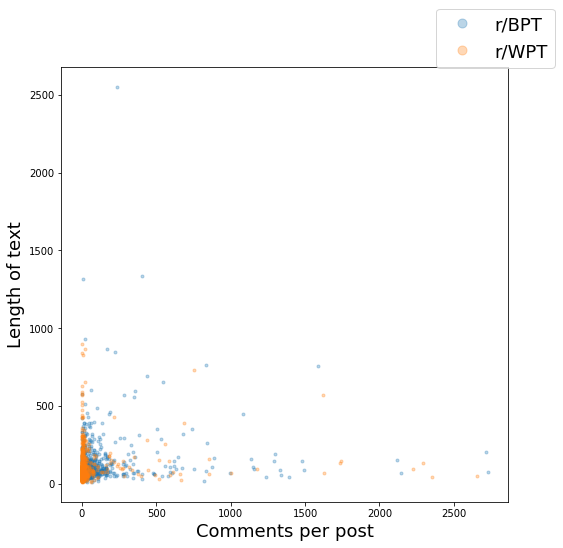

In [16]:
make_corrplot(df['comments_this_post'], df['length_of_text'], df, 'Comments per post', 'Length of text', 'comments-chars.png')

Looks like the posts are pretty mixed, with only the outliers really standing out. The vast majority of the data is clumped near the origin for all pariplots, which setting the transparency of the scatterplots really shows.

The more popular class, `r/BlackPeopleTwitter`, captures most of the outliers. This isn't surprising. It's a more popular subreddit with more users, and appears on the front page regularly.

## Classifiers
### Text-only

The simplest NLP model will look only at text (only the `total_text` column) with subreddit as the target (`class`). First, a train-test split:

In [17]:
target = 'class'
features = 'total_text'
X_train, X_test, y_train, y_test = train_test_split(df[features], 
                                                    df[target], 
                                                    stratify = df[target], 
                                                    random_state = 1453)

First, we're going to use the simplest bag-of-words approach and transform the data using `CountVectorizer`, and fit it to a logistic regression model.

Model fitting time: 0.0145721435546875
Model scoring time: 0.15707111358642578
Mean cross-val score: 67.94%
Cross-val score standard deviation: 4.37%
Model Score on test data: 68.42%
--
Model prediction time: 8.58306884765625e-05
Area under ROC curve Score on test data: 74.49%


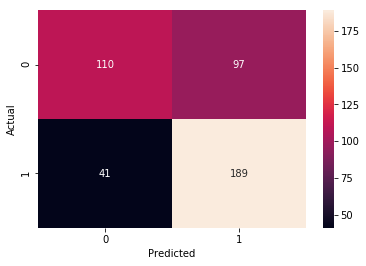

In [18]:
cvec = CountVectorizer(ngram_range=(1,2), stop_words='english')
X_train_cvec = cvec.fit_transform(X_train)
X_test_cvec = cvec.transform(X_test)
lr = LogisticRegression(C=40)

fit_and_make_report(
    model = lr,
    X_train = X_train_cvec,
    y_train = y_train,
    X_test = X_test_cvec,
    y_test = y_test
)

So I've taken just the words, and gotten a model that does better than guessing. Will Tf-Idf vectorization help?

Model fitting time: 0.005448102951049805
Model scoring time: 0.07306909561157227
Mean cross-val score: 68.01%
Cross-val score standard deviation: 4.43%
Model Score on test data: 69.11%
--
Model prediction time: 0.00026798248291015625
Area under ROC curve Score on test data: 73.36%


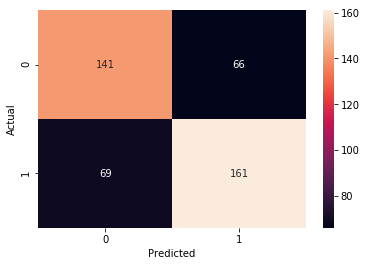

In [19]:
tvec = TfidfVectorizer(ngram_range=(1,3), stop_words='english')
X_train_tvec = tvec.fit_transform(X_train)
X_test_tvec = tvec.transform(X_test)
lr = LogisticRegression(C=40)
fit_and_make_report(
    model = lr,
    X_train = X_train_tvec,
    y_train = y_train,
    X_test = X_test_tvec,
    y_test = y_test
)

Tf-Idf leads to a higher variance model, which has a slightly better false positive rate at the expense of a  worse false negative rate. I'm going to stick with CountVectorizer transformations.

## Other models to try on the text-only data
### AdaBoost

Model fitting time: 0.30295825004577637
Model scoring time: 2.870983123779297
Mean cross-val score: 63.66%
Cross-val score standard deviation: 4.94%
Model Score on test data: 64.30%
--
Model prediction time: 0.0006430149078369141
Area under ROC curve Score on test data: 63.72%


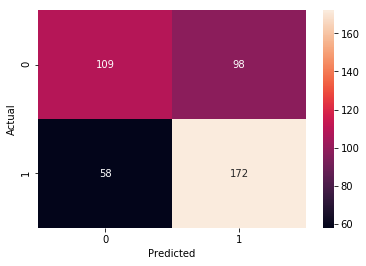

In [20]:
ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=60)
fit_and_make_report(
    model = ada,
    X_train = X_train_cvec,
    y_train = y_train,
    X_test = X_test_cvec,
    y_test = y_test
)

Rather worse...

### GradientBoostingClassifier

Model fitting time: 0.47574806213378906
Model scoring time: 24.03922200202942
Mean cross-val score: 63.59%
Cross-val score standard deviation: 3.83%
Model Score on test data: 61.78%
--
Model prediction time: 0.0010712146759033203
Area under ROC curve Score on test data: 65.79%


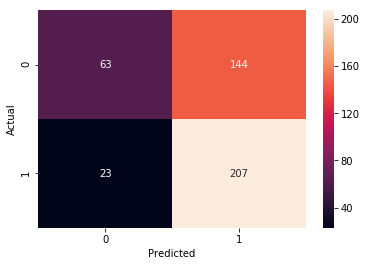

In [21]:
gbc = GradientBoostingClassifier(n_estimators=60)

fit_and_make_report(
    model = gbc,
    X_train = X_train_cvec,
    y_train = y_train,
    X_test = X_test_cvec,
    y_test = y_test
)

Not much better than AdaBoost...
### RandomForest

Model fitting time: 0.4990689754486084
Model scoring time: 22.769052267074585
Mean cross-val score: 64.58%
Cross-val score standard deviation: 3.21%
Model Score on test data: 61.10%
--
Model prediction time: 0.04020380973815918
Area under ROC curve Score on test data: 72.56%


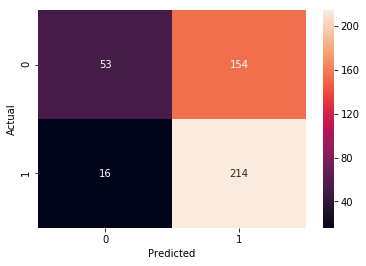

In [22]:
rf = RandomForestClassifier(n_estimators=60)
fit_and_make_report(
    model = rf,
    X_train = X_train_cvec,
    y_train = y_train,
    X_test = X_test_cvec,
    y_test = y_test
)

**Logistic regression with the simplest bag-of-words seems to be the best with the text data in its current state.**

## More complex model

Now that we've seen the limitations of using this limited amount of text alone, let's try to build a stronger model using more features.

In [23]:
list(df.columns) # More easily-readable way to display the number of columns.

['comments_this_post',
 'ups',
 'time_on_reddit',
 'total_text',
 'length_of_text',
 'class']

Transforming the data is a little more complicated now. For the sake of memory, I want a sparse matrix. For the sake of scaling, the numeric features will be min-max scaled. They are then appended to the transformed text matrix and then made sparse.

In [24]:
numerics = ['comments_this_post',
 'ups',
 'time_on_reddit',
 'length_of_text']

minmax = MinMaxScaler()
df[numerics] = minmax.fit_transform(df[numerics])

features = [col for col in df.columns if col != target]
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], random_state = 1204)
cvec = CountVectorizer(ngram_range=(1,3))
X_train = csr_matrix(np.append(cvec.fit_transform(X_train['total_text']).todense(), X_train[numerics].values, 1))
X_test = csr_matrix(np.append(cvec.transform(X_test['total_text']).todense(), X_test[numerics].values, 1))

## Models
### Logistic regression
The one to beat!

Model fitting time: 2.015779972076416
Model scoring time: 10.795541048049927
Mean cross-val score: 66.10%
Cross-val score standard deviation: 4.51%
Model Score on test data: 69.11%
--
Model prediction time: 0.00034618377685546875
Area under ROC curve Score on test data: 76.19%


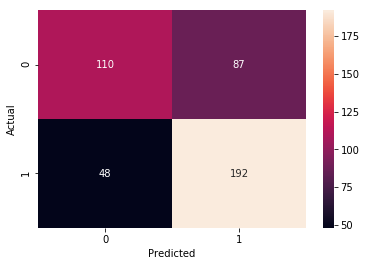

In [25]:
logreg = LogisticRegression()
logreg_params = {
    'C': np.logspace(-1,2,4),
    'penalty':['l1','l2']
}

fit_and_make_report(GridSearchCV(logreg, logreg_params), X_test=X_test, X_train=X_train, y_test=y_test, y_train=y_train)

### Boosting

Model fitting time: 0.24825596809387207
Model scoring time: 3.199300765991211
Mean cross-val score: 81.07%
Cross-val score standard deviation: 2.49%
Model Score on test data: 77.80%
--
Model prediction time: 0.0007529258728027344
Area under ROC curve Score on test data: 77.84%


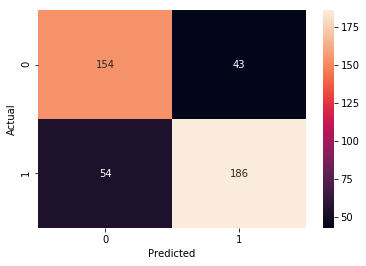

In [26]:
ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=60)
fit_and_make_report(ada, X_test=X_test, X_train=X_train, y_test=y_test, y_train=y_train)

### Random Forest

Model fitting time: 0.11200881004333496
Model scoring time: 3.175344705581665
Mean cross-val score: 76.65%
Cross-val score standard deviation: 4.49%
Model Score on test data: 79.86%
--
Model prediction time: 0.0046482086181640625
Area under ROC curve Score on test data: 85.38%


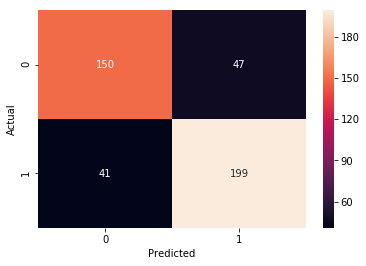

In [27]:
rf = RandomForestClassifier()
fit_and_make_report(rf, X_test=X_test, X_train=X_train, y_test=y_test, y_train=y_train)

### Feature importances

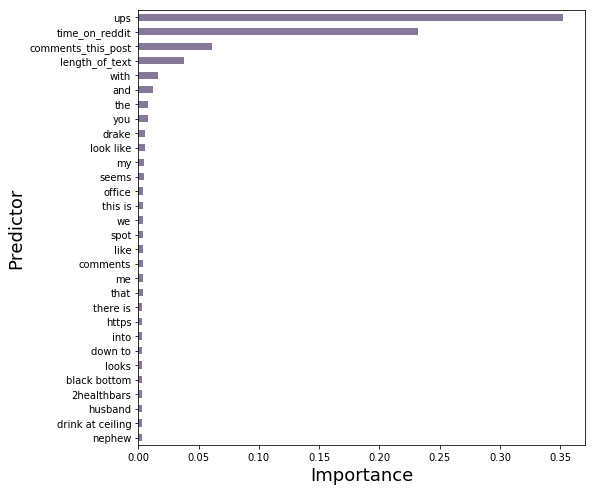

In [28]:
show_best_features(ada, 'AdaBoost', cvec, numerics)

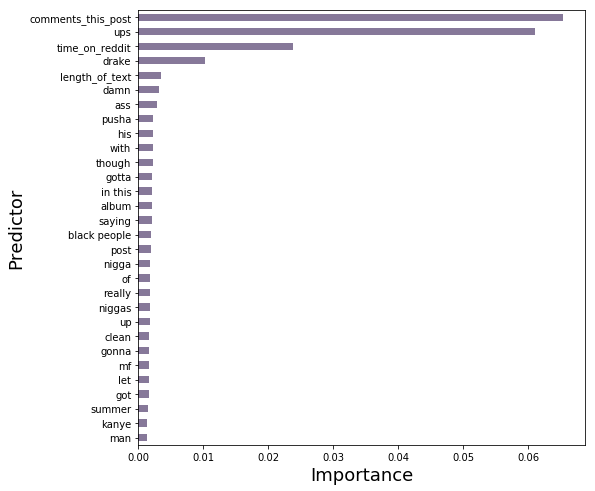

In [29]:
show_best_features(rf, "RandomForest", cvec, numerics)

## Pickling the model and the transformer
These will be used in the next notebook

In [34]:
name = 'model.pkl'
out = open(name, 'wb')
pickle.dump(rf, out)
out.close()

In [35]:
name = 'vectorizer.pkl'
out = open(name, 'wb')
pickle.dump(cvec, out)
out.close()